# Accessing CMIP6 models from Pangeo cloud and basic plotting
This Jupyter notebook shows you how to access CMIP6 model outputs using the Pangeo Cloud Collection through the `intake` and `cmip6_preprocessing` libraries. The second part of this notebook shows you how to do basic data manipulation using the `xarray` library. The last part shows you how to create maps and basic timeseries plots using the `matplotlib` and `cartopy` libraries.

## Loading relevant libraries

In [1]:
#These libraries allow you to access the CMIP6 data from Pangeo Cloud
import intake
from cmip6_preprocessing.preprocessing import combined_preprocessing
#These libraries are used to manipulate data
import xarray as xr
import numpy as np
#This library is handy to deal with filepaths in your computer
import os
#These libraries allow you to create plots, including maps
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft


In [2]:
#This line will show plots you create inside this notebook
%matplotlib inline

## Accessing CMIP6 data with `intake` and `cmip6_preprocessing`
The `intake` library makes it easy to load data that is hosted online with ease into Python. For more information about the function available in this package, you can check its documentation [here](https://intake.readthedocs.io/en/latest/start.html). The `cmip6_preprocessing` library helps you standardised data from different CMIP6 models so you can focus on analysing data faster. Their [website](https://cmip6-preprocessing.readthedocs.io/en/latest/tutorial.html) provides some great tutorials to get you started.

In [3]:
#First we establish a connection to the Pangeo Cloud. The URL below is where CMIP6 data is hosted.
pangeo_collection = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [5]:
#We can now print some of the datasets available through Pangeo. Note that we are printing only the last 10 lines.
#You can remove tail() if you would like to print all entries.
pangeo_collection.df.tail(10)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
514951,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,clivi,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514952,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,rlut,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514953,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,pr,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514954,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,psl,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514955,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,ta,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514956,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514957,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tauu,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514958,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hur,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514959,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hus,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514960,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tauv,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207


The first column shows the row number, as you can see there is almost 515,000 CMIP6 datasets available through Pangeo. For this notebook, we will focus on just one model: ACCESS-ESM 1.5. Pangeo Cloud has a number of other models available, you can check the [World Climate Research Programme (WCRP)](https://www.wcrp-climate.org/modelling-wgcm-mip-catalogue/modelling-wgcm-cmip6-endorsed-mips) website for a list of models and variables available.

It is worth noting that variable names in all CMIP6 models are standarised. You can search for the name of the variable of your interest in this [website](https://clipc-services.ceda.ac.uk/dreq/mipVars.html). For this notebook, we have chosen to access sea surface temperature (SST).

In [11]:
#Since we have hundreds of thousands of datasets available, we will use the search function to find the model (ACCESS-ESM 1.5) 
# and variable (SST) we are interested in
query = pangeo_collection.search(variable_id = 'tos', #this is the standardised CMIP6 variable name for SST
                                 experiment_id = 'historical', #refers to historical data, which covers the years between 1850 and 2014
                                 source_id = 'ACCESS-ESM1-5', #model of interest
                                 table_id = 'Omon', #refers to monthly data for variables related to the ocean
                                 member_id = 'r3i1p1f1') #model run we are interested in

In [12]:
#We can check the results of our query
query.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CSIRO,ACCESS-ESM1-5,historical,r3i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/hist...,NaN,20191203


Now that we identified the datasets of our interest, we will save this information into our memory.

In [13]:
data_dict = query.to_dataset_dict(zarr_kwargs={'consolidated': False, #Standarises data from all models - Not needed if using one model
                                                 'use_cftime': True}, #Save date/time in cftime format
                                    storage_options = {'token': 'anon'}, #Accessing data in Pangeo Cloud
                                    aggregate = False) #No aggregation is needed as we are using one model only


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [16]:
#We can check the dataset in memory, which is currently stored as a Python dictionary
data_dict

{'CMIP.CSIRO.ACCESS-ESM1-5.historical.r3i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r3i1p1f1/Omon/tos/gn/v20191203/.nan.20191203': <xarray.Dataset>
 Dimensions:             (i: 360, j: 300, time: 1980, bnds: 2, vertices: 4)
 Coordinates:
   * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
   * j                   (j) int32 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
     latitude            (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
     longitude           (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
   * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
     time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
 Dimensions without coordinates: bnds, vertices
 Data variables:
     tos                 (time, j, i) float32 dask.array<chunksize=(201, 300, 360), meta=np.ndarray>
     vertices_latitude   (j, i, vertices) float64 

## Data manipulation and visualisation
In this section we will rely on the `xarray` library to manipulate the CMIP6 data that we have loaded into memory.

In [17]:
#We have three variables available in the dataset we loaded, but "tos" is where the SST data is stored.
sst = data_dict['CMIP.CSIRO.ACCESS-ESM1-5.historical.r3i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r3i1p1f1/Omon/tos/gn/v20191203/.nan.20191203'].tos
sst

<xarray.DataArray 'tos' (time: 1980, j: 300, i: 360)>
dask.array<open_dataset-7436444f66724b4cc3afb9d67c27fbcftos, shape=(1980, 300, 360), dtype=float32, chunksize=(201, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
    latitude   (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    history:        2019-12-03T10:07:53Z altered by CMOR: replaced missing va...
    long_name:      Sea Surface Temperature
    standard_name:  sea_surface_temperature
    units:          degC

We can see above that there is SST data from 1850 to 2014. Let's assume that we are only interested in the last 50 years (1964-2014). We can subset the dataset using the function `sel` as shown below.

In [18]:
#Note that "time" is the coordinate with dates. We use "slice" to provide a range of values.
sst_50yrs = sst.sel(time = slice('1964', '2014'))
sst_50yrs

<xarray.DataArray 'tos' (time: 612, j: 300, i: 360)>
dask.array<getitem, shape=(612, 300, 360), dtype=float32, chunksize=(201, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
    latitude   (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
  * time       (time) object 1964-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    history:        2019-12-03T10:07:53Z altered by CMOR: replaced missing va...
    long_name:      Sea Surface Temperature
    standard_name:  sea_surface_temperature
    units:          degC

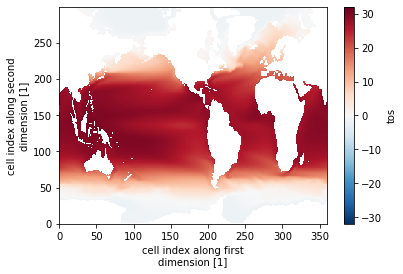

In [20]:
#If we want to create a map of the mean SST during this period, we just need one line.
sst_50yrs.mean('time').plot()

You may have noticed that this map looks rather strange. This is because the plotting function is using the indices provided in the `i` and `j` dimensions, instead of latitude and longitude values. We can correct this fairly easily.

In [31]:
#Correcting longitude. Using values in the longitude dimension.
sst_50yrs.coords['i'] = sst_50yrs['longitude'][0].values
#We do the same with the latitude.
sst_50yrs.coords['j'] = sst_50yrs['latitude'][:,0].values

#Finally, we need to sort the data by longitude before plotting.
sst_50yrs = sst_50yrs.sortby(sst_50yrs.i)

Let's check what our map looks like now. We will use the first time step only.

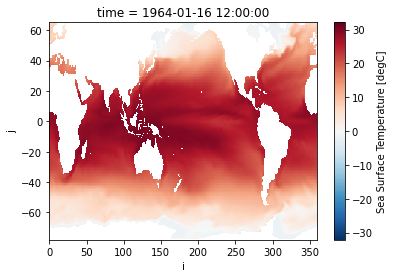

In [32]:
sst_50yrs[0].plot()

In [34]:
#We can change the names of our dimensions to something that makes more sense to us.
sst_50yrs = sst_50yrs.rename({'i': 'lon', 'j': 'lat'})

The map is looking a lot better now. But, let's say that we would like to focus on a specific part of the world, such as Australia. We use the `sel` function again.

In [40]:
#We can use more than one variable with "sel"
sst_aus = sst_50yrs.sel(lon = slice(110, 160), lat = slice(-50, -5))
sst_aus

<xarray.DataArray 'tos' (time: 612, lat: 66, lon: 50)>
dask.array<getitem, shape=(612, 66, 50), dtype=float32, chunksize=(201, 66, 50), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float64 110.5 111.5 112.5 113.5 ... 156.5 157.5 158.5 159.5
  * lat        (lat) float64 -49.63 -48.75 -47.86 -46.96 ... -5.834 -5.5 -5.167
    latitude   (lat, lon) float64 dask.array<chunksize=(66, 50), meta=np.ndarray>
    longitude  (lat, lon) float64 dask.array<chunksize=(66, 50), meta=np.ndarray>
  * time       (time) object 1964-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    history:        2019-12-03T10:07:53Z altered by CMOR: replaced missing va...
    long_name:      Sea Surface Temperature
    standard_name:  sea_surface_temperature
    units:          degC

We can now create a map with the climatological SST mean. This map will use a Mercator projection.

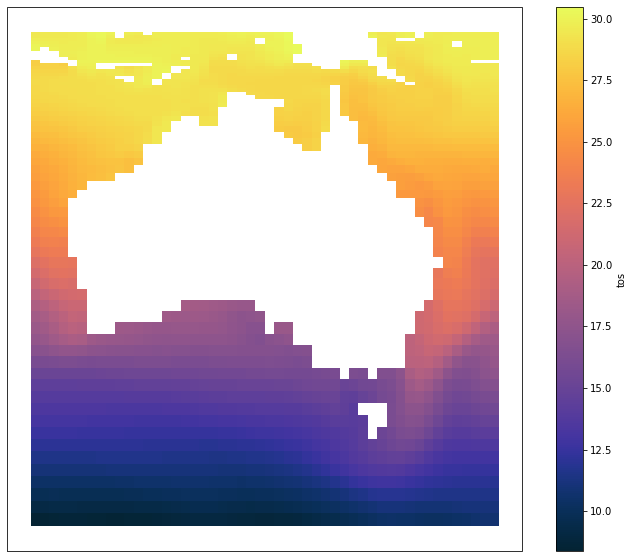

In [42]:
#Let's initialise a figure. We can even set the size of the figure.
fig = plt.figure(figsize = (12, 10))

#We define our projection to be Mercator
proj = ccrs.Mercator()

#We will add the map to the figure
ax = fig.add_subplot(1, 1, 1, projection = proj)

#We calculate the climatological mean as seen in the previous step, and plot results
sst_aus.mean('time').plot.pcolormesh(ax = ax, 
#We will use a colour map designed for temperature plots
transform = ccrs.PlateCarree(), cmap = cm.cm.thermal)

This map is looking better than our first attempt, but we can still make some improvements. We can add a layer for land and change the location and labels of the color bar.

Text(0.5, 1.0, 'Climatological sea surface temperature mean (1964-2014)')

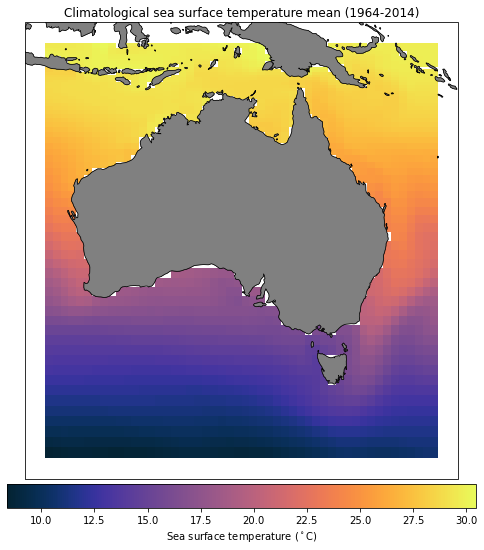

In [43]:
#We use the same base code as the previous box
#Let's initialise a figure
fig = plt.figure(figsize = (12, 10))

#We define our projection to be Mercator
proj = ccrs.Mercator()

#We will add the map to the figure
ax = fig.add_subplot(1, 1, 1, projection = proj)

#Let's add a land layer from the cartopy library
land = cft.NaturalEarthFeature('physical', 'land', '50m',
#We can change the border color and width as well as the colour of the polygon
edgecolor = 'black', linewidth = 0.5, facecolor = 'gray')

#We calculate the climatological mean as seen in the previous step, and plot results
map = sst_aus.mean('time').plot.pcolormesh(ax = ax, 
#We will use a colour map designed for temperature plots
transform = ccrs.PlateCarree(), cmap = cm.cm.thermal,
#We will remove the colourbar so we can personalise it
add_colorbar = False)


#Changing the colourbar - let's plot it horizontally
cb = fig.colorbar(map, ax = ax, orientation = 'horizontal',
#we will also reduce its size and decrease the space between the map and the bar
shrink = 0.6, pad = 0.01)

#Now we can change the color bar label
cb.ax.set_xlabel('Sea surface temperature ($^\circ$C)')

#Now we add coastlines and the land layer
ax.coastlines(resolution = '50m')
ax.add_feature(land)

#Finally we add a title
ax.set_title('Climatological sea surface temperature mean (1964-2014)')


If we are interested in calculating yearly means or seasonal means, we can use the `groupby` function to do this.

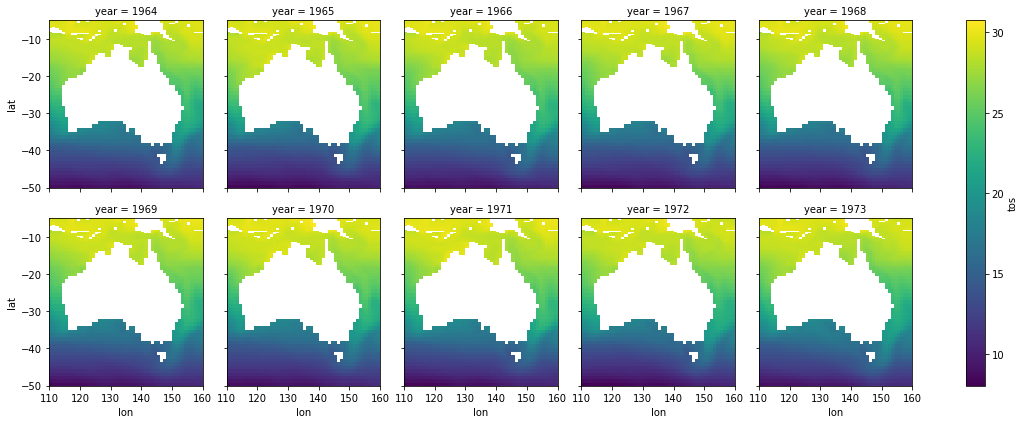

In [44]:
#Calculating annual SST means
annual_sst = sst_aus.groupby('time.year').mean('time')

#Let's check the results. We will plot only the first 10 years
annual_sst[0:10].plot(col = 'year', col_wrap = 5)

We can also summarise data to plot time series. Let's plot SST anomalies as an example.

In [45]:
#We will first calculate and save the climatological mean
aus_clim = sst_aus.mean('time')

In [46]:
#We can calculate the anomalies using the year means
anom_yrs = annual_sst-aus_clim
anom_yrs

<xarray.DataArray 'tos' (year: 51, lat: 66, lon: 50)>
dask.array<sub, shape=(51, 66, 50), dtype=float32, chunksize=(1, 66, 50), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float64 110.5 111.5 112.5 113.5 ... 156.5 157.5 158.5 159.5
  * lat        (lat) float64 -49.63 -48.75 -47.86 -46.96 ... -5.834 -5.5 -5.167
    latitude   (lat, lon) float64 dask.array<chunksize=(66, 50), meta=np.ndarray>
    longitude  (lat, lon) float64 dask.array<chunksize=(66, 50), meta=np.ndarray>
  * year       (year) int64 1964 1965 1966 1967 1968 ... 2011 2012 2013 2014

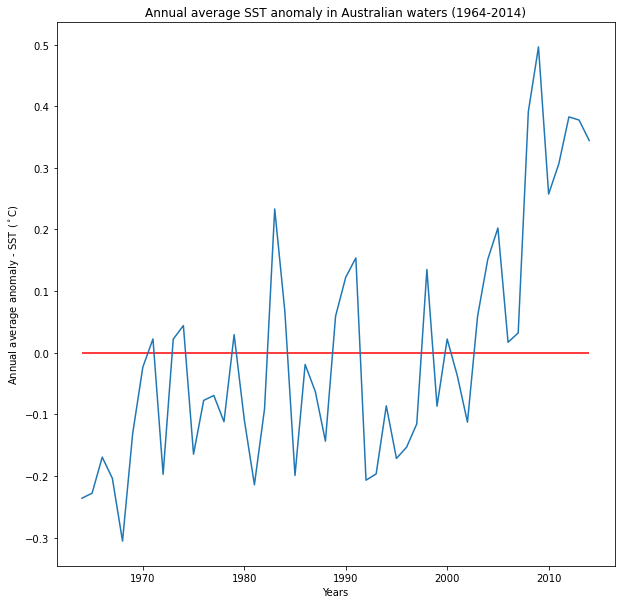

In [47]:
#We initiliase our figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)

#Before plotting, we calculate the mean over space 
anom_yrs.mean(('lon', 'lat')).plot()
#Let's include a horizontal line along zero, so it is easier to see if anomalies are positive or negative
plt.hlines(0, colors = 'red', xmin = anom_yrs.year.values.min(), 
xmax =  anom_yrs.year.values.max())

#We add label names to axes
ax.set_xlabel('Years')
ax.set_ylabel('Annual average anomaly - SST ($^\circ$C)')

#We add a title to the figure
ax.set_title('Annual average SST anomaly in Australian waters (1964-2014)')

#If we like our plot, we can save the result
folder_out = 'Figure'
#We can check if a folder exists with the following line. If no folder exists, it will create one.
os.makedirs(folder_out, exist_ok = True)

fig.savefig(os.path.join(folder_out, 'AustraliaSSTanomYr_1964-2014.png'), dpi = 300)